In [39]:
import numpy as np
import pandas as pd
from pathlib import Path
# from scipy.stats import gaussian_kde
# from sklearn import preprocessing, decomposition
# from IPython import display
from matplotlib import pyplot as plt, ticker, lines
plt.style.use("minimal")

%precision 3

'%.3f'

In [10]:
# display.Image("../Export/full.gif")

In [69]:
METADATA_ROWS_N     = 9 # number of lines to skip in logfile
SPATIAL_SCALE       = 1000 # spatial measurements were recorded in millimeters
SAMPLE_RATE         = 300 # Hz (samples/second)
DISPATCH_MARGIN     = 0.4 # number of seconds before dispatch to consider in analysis
IGNORED_MARKERS     = ["Table", "TableEdge", "CupFront", "CupLeft", "CupRight", "CupFront_static", "CupLeft_static", "CupRight_static"]
CUP_RADIUS          = 4.6 # radius of cup in cm
DATA_PATH           = "../data" # path to logfile directories

In [74]:
class Recording:
    def __init__(self, datafile_path):
        self.read_datafile(datafile_path)
        self.enhance()

    def read_datafile(self, datafile_path):
        self.events = pd.read_csv(
            datafile_path, 
            sep = "\t", 
            header = None, 
            names = ("Type", "EventType", "Frame", "Time"), 
            skiprows = METADATA_ROWS_N, 
            on_bad_lines = "skip"
        )

        marker_names = pd.read_csv(
            datafile_path, 
            sep = "\t", 
            header = None, 
            skiprows = METADATA_ROWS_N + len(self.events), 
            nrows = 1
        ).loc[0, 1:].values

        self.available_markers = list(sorted(marker_names))

        dataset = pd.read_csv(
            datafile_path, 
            sep = "\t", 
            header = METADATA_ROWS_N + len(self.events) + 2, 
            usecols = lambda name: "Unnamed" not in name
        ).drop(columns = [f"{marker} {axis}" for axis in ["X", "Y", "Z"] for marker in IGNORED_MARKERS])

        dataset = dataset.set_index("Time")
        dataset.columns = dataset.columns.str.split(" ", expand = True)
        dataset = dataset.stack(0, dropna = False)
        dataset.index = dataset.index.rename(["Time", "Marker"])
        dataset = dataset.reset_index()

        dataset["TrialTag"] = dataset["Time"].isin(self.events[self.events["EventType"] == "Trial"]["Time"])
        dataset["Trial"] = (dataset["TrialTag"].astype(int).diff() > 0).cumsum()
        dataset = dataset[dataset["Trial"] > 0]

        trials = []
        for trial, segment in dataset.groupby("Trial"):
            segment["Time"] -= segment["Time"].min()
            trials.append(Trial(segment))

        self.data = pd.Series(data = trials, index = np.arange(1, len(trials) + 1), name = "Trial")

    def calculate_speed(self, subset):
        delta_pos = (subset[["X", "Y", "Z"]].shift(1).values - subset[["X", "Y", "Z"]].values) * SAMPLE_RATE
        speed = np.sqrt(np.sum(delta_pos ** 2, axis = 1))
        speed = pd.Series(speed).rolling(int(SAMPLE_RATE / 10)).mean() # smoothen with rolling average
        speed /= 100 # rescale from cm/s to m/s
        return speed

    def calculate_acceleration(self, subset):
        return (subset["Speed"].diff() / SAMPLE_RATE).rolling(int(SAMPLE_RATE / 10)).mean() # smoothen with rolling average

    def sync_and_trim(self, subset, reference_timepoint, pre = None, post = None):
        if pre and post:
            subset = subset[(subset["Time"] > reference_timepoint - pre) & (subset["Time"] < reference_timepoint + post)].copy()
        subset["Time"] -= subset["Time"].min()
        subset.index -= subset.index.min()
        return subset

    def recenter_to_cup(self, subset, cup_centroid):
        subset[["X", "Y", "Z"]] = subset[["X", "Y", "Z"]].subtract(cup_centroid)
        return subset

    def enhance(self):
        self.cup_centroid = self.data[1]["CupCentroid"].iloc[0][["X", "Y", "Z"]]
        for trial in self.data.index:
            # adding derived measures
            for marker in self.data[trial].index:
                self.recenter_to_cup(self.data[trial][marker], self.cup_centroid)
                self.data[trial][marker]["Speed"] = self.calculate_speed(self.data[trial][marker])
                self.data[trial][marker]["Acceleration"] = self.calculate_acceleration(self.data[trial][marker])

            # trimming to throw by using max ball speed (terminal velocity)
            reference_timepoint = self.data[trial]["Ball"]["Time"][self.data[trial]["Ball"]["Speed"].replace(np.nan, 0).idxmax()]
            for marker in self.data[trial].index:
                self.data[trial][marker] = self.sync_and_trim(
                    self.data[trial][marker], 
                    reference_timepoint, 
                    pre = 1, 
                    post = DISPATCH_MARGIN
                )

            # trimming and "centering" around throw movement instead of terminal velocity
            reference_timepoint = self.data[trial]["Ball"]["Time"][self.data[trial]["Ball"]["Acceleration"].replace(np.nan, 0).idxmax()]
            for marker in self.data[trial].index:
                self.data[trial][marker] = self.sync_and_trim(
                    self.data[trial][marker], 
                    reference_timepoint, 
                    pre = DISPATCH_MARGIN, 
                    post = 0.6
                )

    def __repr__(self):
        return f"[Recording {self.id}] {len(self.data)} trials"

class Trial(pd.Series):
    def __init__(self, data, *args, **kwargs):
        pd.Series.__init__(self, {marker: self.process_marker_data(data) for marker, data in tuple(data.groupby("Marker", as_index = False))}, *args, **kwargs)
        self.determine_outcome()

    def process_marker_data(self, marker_data):
        data = marker_data[["Time", "X", "Y", "Z"]]
        data = data.set_index("Time")
        data = data.interpolate(limit_direction = "both")
        data = (data / SPATIAL_SCALE) * 100 # rescale from mm/s to cm
        return data.reset_index()
    
    def determine_outcome(self):
        ball_height_relative_to_cup_centroid = self["Ball"]["Z"].values - self["CupCentroid"]["Z"].values
        ball_xy_distance_to_cup_centroid = np.sqrt(np.sum((self["Ball"][["X", "Y"]].values - self["CupCentroid"][["X", "Y"]].values)**2, axis = 1))
        self.outcome = ((ball_height_relative_to_cup_centroid <= 0) & (ball_xy_distance_to_cup_centroid < CUP_RADIUS)).any()

    def __repr__(self):
        return f"[Trial] {'Hit' if self.outcome else 'Miss'}"

class Session:
    def __init__(self, session_id):
        self.session_id = session_id

        recordings = []
        for recording_path in Path(DATA_PATH).joinpath(f"Session{self.session_id}").iterdir():
            if recording_path.suffix == ".tsv":
                recordings.append(dict(
                    Player = int(recording_path.name[6]),
                    Condition = recording_path.stem.split("_")[1],
                    Recording = Recording(datafile_path=recording_path).data
                ))
        self.data = pd.DataFrame(recordings)

    def __repr__(self):
        return f"[Session {self.session_id}]" + "\n" + self.data[["Player", "Condition"]].to_string(index = False)

session = Session(session_id = 5)
print(session)

data = session.data

[Session 5]
 Player Condition
      1  Darkness
      1  Daylight
      2  Darkness
      2  Daylight


In [22]:
def annotate_metadata(marker, axis = None):
    plt.figtext(0.9, 0.9, f"{marker}" + f"{' ' + axis if axis else ''}", ha = "center")
    # plt.figtext(1, 0.04, f"{len(data)} trials", ha = "center", alpha = 0.5)

def mark_dispatch():
    plt.axvline(DISPATCH_MARGIN, color = "black", linestyle = "--", linewidth = 1, alpha = 0.05, zorder = -1)

def decorate_xaxis_ticks():
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.gca().xaxis.set_major_formatter(lambda val, idx: int(val * 1000))
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.05))

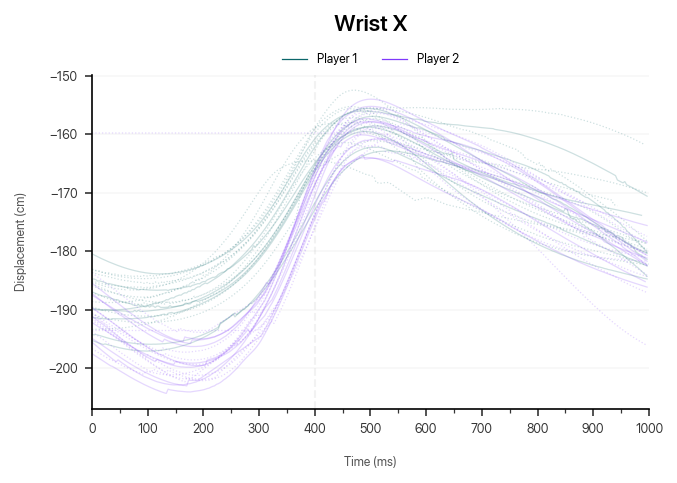

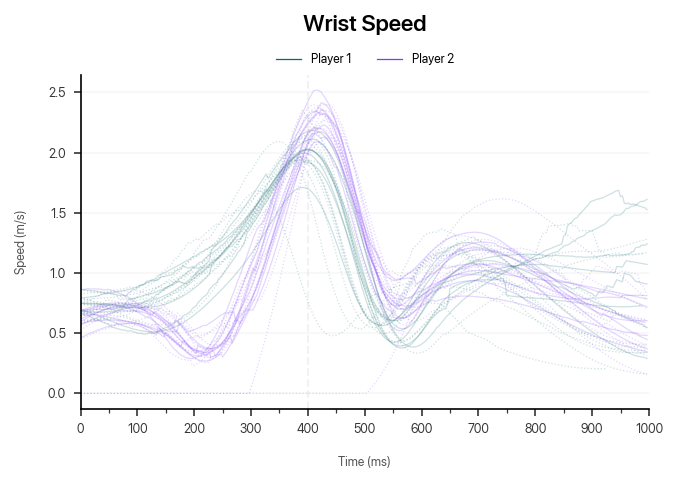

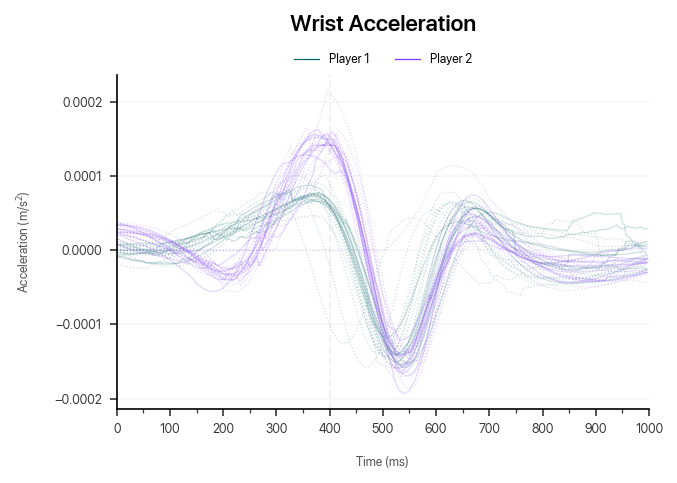

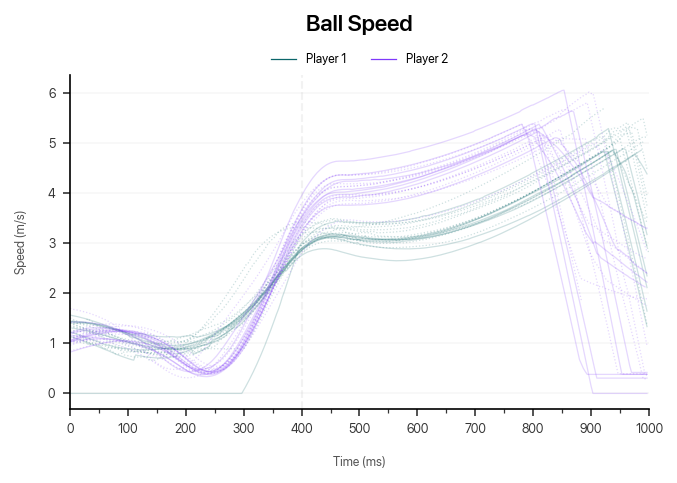

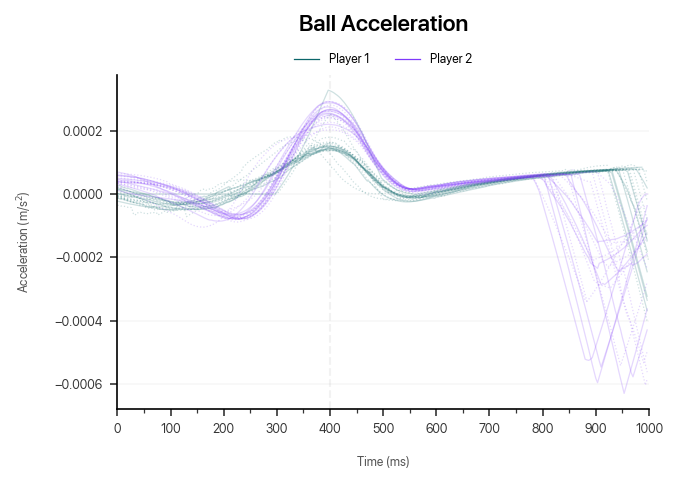

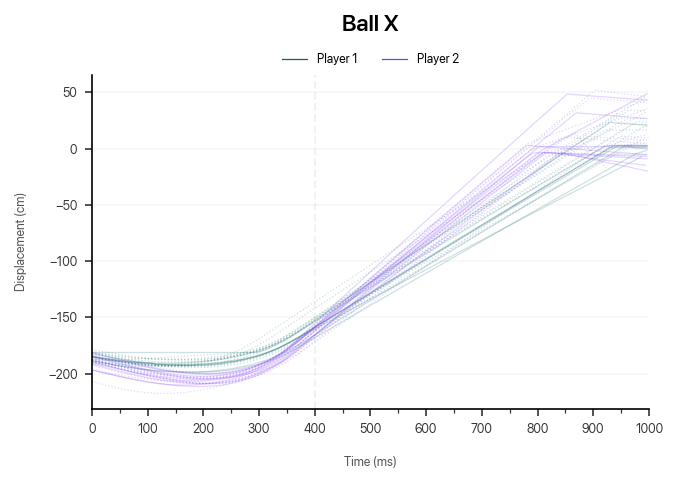

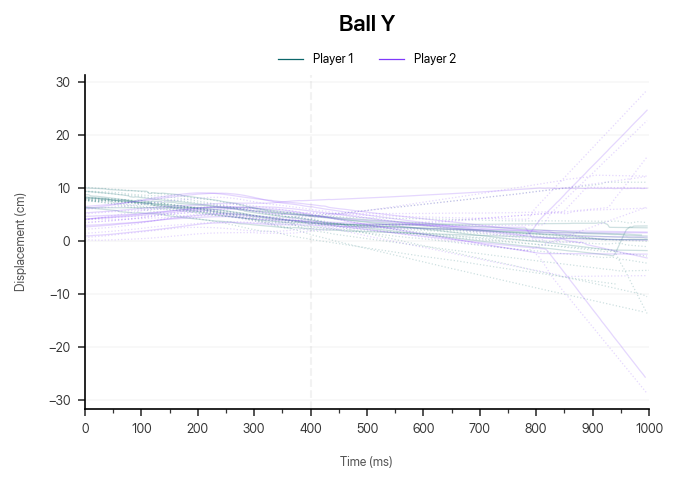

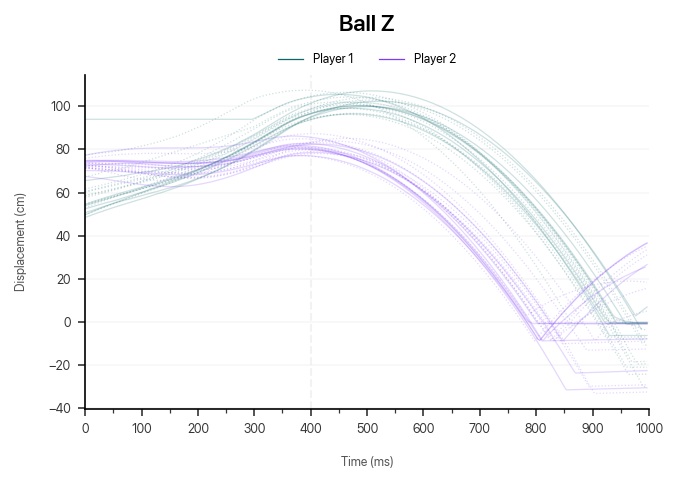

In [75]:
def plot_trajectory(marker, dimension):
    plt.figure()
    mark_dispatch()
    for index, (player, condition, recording) in data.iterrows():
        for trial, subset in recording.items():
            plt.plot(
                subset[marker]["Time"],
                subset[marker][dimension], 
                color = "C0" if player == 1 else "C2",
                linewidth = 0.6, 
                linestyle = "-" if subset.outcome else ":",
                alpha = 0.2
            )

    plt.title(f"{marker} {dimension}\n")
    plt.xlabel("Time (ms)")
    if dimension == "Speed":
        plt.ylabel(f"{dimension} (m/s)")
    elif dimension == "Acceleration":
        plt.ylabel(f"{dimension} (m/s$^2$)")
    else:
        plt.ylabel("Displacement (cm)")

    decorate_xaxis_ticks()
    plt.legend(handles = [lines.Line2D([0], [0], color=color, linewidth = 0.6) for color in ("C0", "C2")], labels = ["Player 1", "Player 2"], loc = "upper center", bbox_to_anchor = (0.5, 1.1), ncol = 2)
    plt.margins(x = 0, y = 0.05)
    plt.tight_layout()

plot_trajectory(marker = "Wrist", dimension = "X")
plot_trajectory(marker = "Wrist", dimension = "Speed")
plot_trajectory(marker = "Wrist", dimension = "Acceleration")
plot_trajectory(marker = "Ball", dimension = "Speed")
plot_trajectory(marker = "Ball", dimension = "Acceleration")
plot_trajectory(marker = "Ball", dimension = "X")
plot_trajectory(marker = "Ball", dimension = "Y")
plot_trajectory(marker = "Ball", dimension = "Z")

In [25]:
def summary():
    result = []
    for index, (player, condition, recording) in data.iterrows():
        for trial, subset in recording.items():

            after_passing_cup = subset["Ball"]["X"] > 0

            result.append({
                "Player": player, 
                "Condition": condition, 
                "Trial": trial, 
                "Outcome": "Hit" if subset.outcome else "Miss",
                "Ball Max Speed (m/s)": subset["Ball"]["Speed"].max(), 
                "Ball Max Altitude (cm)": subset["Ball"]["Z"].max(),
                "Ball Altitude at Cup Projection (cm)": subset["Ball"][after_passing_cup].iloc[0]["Z"] if after_passing_cup.any() else np.nan,
                "Wrist Max Speed (m/s)": subset["Wrist"]["Speed"].max(),
                "Distance to Cup at Dispatch (cm)": -subset["Ball"].iloc[int(DISPATCH_MARGIN * SAMPLE_RATE)]["X"],
                "Deviation from Centerline at Dispatch (cm)": subset["Ball"].iloc[int(DISPATCH_MARGIN * SAMPLE_RATE)]["Y"],
                "Elbow Altitude at Dispatch (cm)": subset["Elbow"]["Z"].loc[subset["Ball"]["Speed"].idxmax()],
            })

    return pd.DataFrame(result).set_index(["Player", "Condition", "Trial"]).round(2)

summary()

Outcome  Ball Max Speed (m/s)  Ball Max Altitude (cm)  \
Player Condition Trial                                                         
1      Darkness  1        Miss                  5.08                  104.39   
                 2        Miss                  5.23                  100.92   
                 3        Miss                  5.02                  102.99   
                 4        Miss                  5.20                  106.58   
                 5        Miss                  5.29                  105.65   
                 6        Miss                  5.70                  107.56   
                 7        Miss                  4.86                  107.22   
                 8        Miss                  5.31                  102.03   
                 9        Miss                  5.12                  104.19   
                 10       Miss                  5.13                  102.09   
       Daylight  1        Miss                  5.32                   99.15   
                 2        Miss                  5.49                   96.82   
                 3         Hit                  4.86                  100.39   
                 4         Hit                  4.83                   96.54   
                 5        Miss                  5.41                   96.30   
                 6         Hit                  4.89                   99.96   
                 7        Miss                  4.77                  102.43   
                 8         Hit                  4.83                   99.17   
                 9        Miss                  4.84                  101.92   
                 10        Hit                  4.87                  100.32   
2      Darkness  1        Miss                  5.81                   83.26   
                 2        Miss                  5.14                   79.89   
                 3        Miss                  6.02                   87.33   
                 4        Miss                  5.00                   85.21   
                 5        Miss                  5.09                   87.83   
                 6        Miss                  5.11                   86.33   
                 7        Miss                  5.15                   84.86   
                 8        Miss                  5.28                   85.80   
                 9        Miss                  6.06                   85.24   
                 10       Miss                  5.39                   86.63   
       Daylight  1        Miss                  5.38                   86.25   
                 2         Hit                  5.38                   80.70   
                 3        Miss                  5.30                   84.98   
                 4        Miss                  5.38                   80.12   
                 5        Miss                  5.28                   77.19   
                 6        Miss                  5.23                   80.31   
                 7         Hit                  5.27                   79.35   
                 8        Miss                  5.65                   78.70   
                 9        Miss                  5.19                   77.27   
                 10       Miss                  5.19                   78.19   

                        Ball Altitude at Cup Projection (cm)  \
Player Condition Trial                                         
1      Darkness  1                                      8.24   
                 2                                     12.18   
                 3                                      2.52   
                 4                                     35.45   
                 5                                     23.68   
                 6                                     16.34   
                 7                                       NaN   
                 8                                     14.30   
                 9    

In [ ]:
# excluded_markers = ["Ball"]
# all_positional_data = pd.concat([data[1][marker][["X", "Y", "Z"]].add_prefix(marker + "_") for marker in session.available_markers if marker not in excluded_markers], axis=1).dropna(axis = 1)
# scaled_data = preprocessing.scale(all_positional_data.T)

# def principal_component_analysis():
#     n_components = 3
#     pca = decomposition.PCA(n_components)
#     pca.fit(scaled_data)
#     component_labels = ["PC" + str(i) for i in range(1, n_components + 1)]

#     plt.figure(figsize=(4.5, 1.5))
#     plt.title("Principal Component Analysis")
#     plt.barh(component_labels[::-1], pca.explained_variance_ratio_[::-1])
#     plt.xlim((0, 1))
#     plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
#     plt.xlabel("Relative importance (weight)")
#     plt.ylabel("Component")
#     plt.tight_layout()

#     plt.figure()
#     pca_data = pd.DataFrame(pca.transform(scaled_data), index = all_positional_data.columns, columns = component_labels)
#     plt.scatter(pca_data["PC1"], pca_data["PC2"], s = 5)
#     for marker, components in pca_data.iterrows():
#         plt.annotate(" " + marker, (components["PC1"], components["PC2"]), fontsize = 6)
#     plt.margins(x = 0.1)
#     plt.xlabel("PC1")
#     plt.ylabel("PC2")
#     plt.tight_layout()

# def independent_component_analysis():
#     n_components = 2
#     ica = decomposition.FastICA(n_components)
#     ica.fit(scaled_data)
#     component_labels = ["IC" + str(i) for i in range(1, n_components + 1)]

#     plt.figure()
#     plt.title("Independent Component Analysis")
#     ica_data = pd.DataFrame(ica.transform(scaled_data), index = all_positional_data.columns, columns = component_labels)
#     plt.scatter(ica_data["IC1"], ica_data["IC2"], s = 5)
#     for marker, components in ica_data.iterrows():
#         plt.annotate(" " + marker, (components["IC1"], components["IC2"]), fontsize = 6)
#     plt.margins(x = 0.1)
#     plt.xlabel("IC1")
#     plt.ylabel("IC2")
#     plt.tight_layout()

# principal_component_analysis()
# independent_component_analysis()